# Create storm-centric response functions with centered composites

In [12]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import datetime
import matplotlib.pyplot as plt
import haversine

from wofunits import wofunits
import centered_response as cr

resp_path = wofunits.paths['resp_path']

## Select WoFS initialization

In [13]:
#case = '201905172100'
#case = '201905172200'
#case = '201905202030'
#case = '201905262000'
case = '201905282230'

# Define case specs
wofs_casedir, file_latlons, file_coords, file_resp_coords, file_mrms_maxima, files_wofs, state_times, resptime = cr.case_sel(case)

## Plot close zoom of storm-centered view to confirm compositing was done correctly

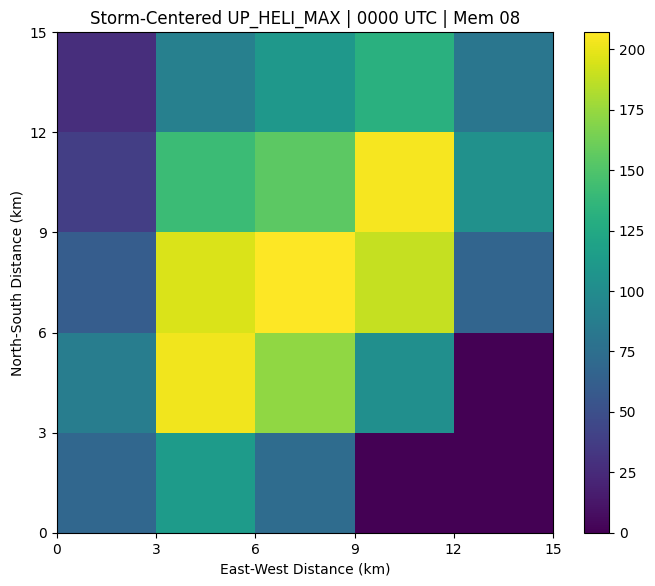

In [14]:
df = cr.create_coords_df(file_resp_coords, file_mrms_maxima) # 5-min response interval

cr.varvis_c(file_latlons, df, '290000', mem=8, var='UP_HELI_MAX')

## Grab max UH$_{25}$, max $\zeta$ ${_2}{_5}$, and W$_{max}$ at mesocyclone center

In [15]:
uhmax_time, wzmax_time, wmax_time, time = [],[],[],[]
for i, (nycol, nxcol) in enumerate(zip(df.columns[0::2], df.columns[1::2])):

    ds = xr.open_dataset(files_wofs[i])
    
    uh_max, wz_max, w_max = [],[],[]
    
    for mem in range(36):
    
        center_ny = df[nycol].values[mem]
        center_nx = df[nxcol].values[mem]

        if center_ny < 0:
            uh_max.append(0.0)
            wz_max.append(0.0)
            w_max.append(0.0)
            continue
        
        max_uh = float(ds['UP_HELI_MAX'][mem,0,center_ny,center_nx].values)
        max_wz = float(np.nanmax(ds['WZ_25'][mem,0,center_ny-2:center_ny+3,center_nx-2:center_nx+3]))
        max_w = float(np.nanmax(ds['W_UP_MAX'][mem,0,center_ny-2:center_ny+3,center_nx-2:center_nx+3]))
        
        uh_max.append(max_uh)
        wz_max.append(max_wz)
        w_max.append(max_w)
    
    uhmax_time.append(uh_max)
    wzmax_time.append(wz_max)
    wmax_time.append(w_max)
    time.append(nxcol[:8])

## Plot histogram across members for sanity check (and verify Gaussianity)

Text(0.5, 1.0, '0035 UTC')

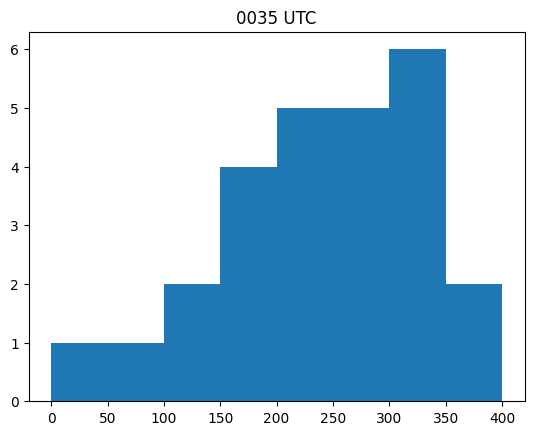

In [44]:
idx=-6 # 5-min intervals

plt.hist(uhmax_time[idx], bins=np.arange(0,450,50))
plt.title(time[idx])

## Save UH response function(s) to file

In [32]:
# Only 30-minute response window saved here; other windows commented out 

#resp_60 = np.nanmax(uhmax_time, axis=0)
resp_30 = np.nanmax(uhmax_time[-7:], axis=0)
#resp_15 = np.nanmax(uhmax_time[-4:], axis=0)
#resp_05 = np.array(uhmax_time[-1])

#ds_respout_60 = xr.Dataset(
#     data_vars=dict(
#         UH25_60MIN=(['NE'], resp_60),
#     ),
#        attrs=dict(DX = '3000',
#                   DY = '3000',
#                   RF_CENTER_LON = np.nan,
#                   RF_CENTER_LAT = np.nan,
#                   RF_X_LEFT = np.nan,
#                   RF_X_RIGHT = np.nan,
#                   RF_Y_BOTTOM = np.nan,
#                   RF_Y_TOP = np.nan,
#                   RESP_VAR = 'UH25_60MIN',
#                   RESP_TIME = resptime,
#                   METHOD = 'max')
#)

ds_respout_30 = xr.Dataset(
     data_vars=dict(
         UH25_30MIN=(['NE'], resp_30),
     ),
        attrs=dict(DX = '3000',
                   DY = '3000',
                   RF_CENTER_LON = np.nan,
                   RF_CENTER_LAT = np.nan,
                   RF_X_LEFT = np.nan,
                   RF_X_RIGHT = np.nan,
                   RF_Y_BOTTOM = np.nan,
                   RF_Y_TOP = np.nan,
                   RESP_VAR = 'UH25_30MIN',
                   RESP_TIME = resptime,
                   METHOD = 'max')
)

#ds_respout_15 = xr.Dataset(
#     data_vars=dict(
#         UH25_15MIN=(['NE'], resp_15),
#     ),
#        attrs=dict(DX = '3000',
#                   DY = '3000',
#                   RF_CENTER_LON = np.nan,
#                   RF_CENTER_LAT = np.nan,
#                   RF_X_LEFT = np.nan,
#                   RF_X_RIGHT = np.nan,
#                   RF_Y_BOTTOM = np.nan,
#                   RF_Y_TOP = np.nan,
#                   RESP_VAR = 'UH25_15MIN',
#                   RESP_TIME = resptime,
#                   METHOD = 'max')
#)

#ds_respout_05 = xr.Dataset(
#     data_vars=dict(
#         UH25_05MIN=(['NE'], resp_05),
#     ),
#        attrs=dict(DX = '3000',
#                   DY = '3000',
#                   RF_CENTER_LON = np.nan,
#                   RF_CENTER_LAT = np.nan,
#                   RF_X_LEFT = np.nan,
#                   RF_X_RIGHT = np.nan,
#                   RF_Y_BOTTOM = np.nan,
#                   RF_Y_TOP = np.nan,
#                   RESP_VAR = 'UH25_05MIN',
#                   RESP_TIME = resptime,
#                   METHOD = 'max')
#)


# Save to file(s)

#ds_respout_60.to_netcdf(path=f'{resp_path}/resp_{ds_respout_60.RESP_VAR}_{ds_respout_60.METHOD}_{ds_respout_60.RESP_TIME}.nc')
ds_respout_30.to_netcdf(path=f'{resp_path}/resp_{ds_respout_30.RESP_VAR}_{ds_respout_30.METHOD}_{ds_respout_30.RESP_TIME}.nc')
#ds_respout_15.to_netcdf(path=f'{resp_path}/resp_{ds_respout_15.RESP_VAR}_{ds_respout_15.METHOD}_{ds_respout_15.RESP_TIME}.nc')
#ds_respout_05.to_netcdf(path=f'{resp_path}/resp_{ds_respout_05.RESP_VAR}_{ds_respout_05.METHOD}_{ds_respout_05.RESP_TIME}.nc')


## Save vorticity response functions to file

In [41]:
# Only 30-minute response window saved here; other windows commented out 

#resp_60 = np.nanmax(wzmax_time, axis=0)
resp_30 = np.nanmax(wzmax_time[-7:], axis=0)
#resp_15 = np.nanmax(wzmax_time[-4:], axis=0)
#resp_05 = np.array(wzmax_time[-1])

#ds_respout_60 = xr.Dataset(
#     data_vars=dict(
#         WZ25_60MIN=(['NE'], resp_60),
#     ),
#        attrs=dict(DX = '3000',
#                   DY = '3000',
#                   RF_CENTER_LON = np.nan,
#                   RF_CENTER_LAT = np.nan,
#                   RF_X_LEFT = np.nan,
#                   RF_X_RIGHT = np.nan,
#                   RF_Y_BOTTOM = np.nan,
#                   RF_Y_TOP = np.nan,
#                   RESP_VAR = 'WZ25_60MIN',
#                   RESP_TIME = resptime,
#                   METHOD = 'max')
#)

ds_respout_30 = xr.Dataset(
     data_vars=dict(
         WZ25_30MIN=(['NE'], resp_30),
     ),
        attrs=dict(DX = '3000',
                   DY = '3000',
                   RF_CENTER_LON = np.nan,
                   RF_CENTER_LAT = np.nan,
                   RF_X_LEFT = np.nan,
                   RF_X_RIGHT = np.nan,
                   RF_Y_BOTTOM = np.nan,
                   RF_Y_TOP = np.nan,
                   RESP_VAR = 'WZ25_30MIN',
                   RESP_TIME = resptime,
                   METHOD = 'max')
)

#ds_respout_15 = xr.Dataset(
#     data_vars=dict(
#         WZ25_15MIN=(['NE'], resp_15),
#     ),
#        attrs=dict(DX = '3000',
#                   DY = '3000',
#                   RF_CENTER_LON = np.nan,
#                   RF_CENTER_LAT = np.nan,
#                   RF_X_LEFT = np.nan,
#                   RF_X_RIGHT = np.nan,
#                   RF_Y_BOTTOM = np.nan,
#                   RF_Y_TOP = np.nan,
#                   RESP_VAR = 'WZ25_15MIN',
#                   RESP_TIME = resptime,
#                   METHOD = 'max')
#)

#ds_respout_05 = xr.Dataset(
#     data_vars=dict(
#         WZ25_05MIN=(['NE'], resp_05),
#     ),
#        attrs=dict(DX = '3000',
#                   DY = '3000',
#                   RF_CENTER_LON = np.nan,
#                   RF_CENTER_LAT = np.nan,
#                   RF_X_LEFT = np.nan,
#                   RF_X_RIGHT = np.nan,
#                   RF_Y_BOTTOM = np.nan,
#                   RF_Y_TOP = np.nan,
#                   RESP_VAR = 'WZ25_05MIN',
#                   RESP_TIME = resptime,
#                   METHOD = 'max')
#)

#ds_respout_60.to_netcdf(path=f'{resp_path}/resp_{ds_respout_60.RESP_VAR}_{ds_respout_60.METHOD}_{ds_respout_60.RESP_TIME}.nc')
ds_respout_30.to_netcdf(path=f'{resp_path}/resp_{ds_respout_30.RESP_VAR}_{ds_respout_30.METHOD}_{ds_respout_30.RESP_TIME}.nc')
#ds_respout_15.to_netcdf(path=f'{resp_path}/resp_{ds_respout_15.RESP_VAR}_{ds_respout_15.METHOD}_{ds_respout_15.RESP_TIME}.nc')
#ds_respout_05.to_netcdf(path=f'{resp_path}/resp_{ds_respout_05.RESP_VAR}_{ds_respout_05.METHOD}_{ds_respout_05.RESP_TIME}.nc')

## Check newly-created response files

In [43]:
ds = xr.open_dataset(f'{resp_path}/resp_{ds_respout_30.RESP_VAR}_{ds_respout_30.METHOD}_{ds_respout_30.RESP_TIME}.nc')

ds['WZ25_30MIN'].values

array([0.00663505, 0.01059013, 0.00845885, 0.0081908 , 0.00922162,
       0.01116016, 0.00921743, 0.00988316, 0.01073158, 0.01222485,
       0.01288826, 0.00847402, 0.01165775, 0.00990709, 0.01090144,
       0.00940688, 0.00875171, 0.0054025 , 0.00832192, 0.01207331,
       0.01201347, 0.00892098, 0.00823629, 0.01096097, 0.00919404,
       0.01138885, 0.00872055, 0.01085066, 0.01064868, 0.01004562,
       0.00972594, 0.01271473, 0.00716646, 0.00794047, 0.00548161,
       0.00746553])